In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [3]:
#from source.utils import *
from source.preprocess import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [4]:
path = "../../Desktop/DLC_social_1/"

# Set up and design the project

In [5]:
with open('{}DLC_social_1_exp_conditions.pickle'.format(path), 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [6]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [7]:
%%time
DLC_social_1 = project(path=path,#Path where to find the required files
                   smooth_alpha=0.85,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.72 s, sys: 818 ms, total: 3.54 s
Wall time: 1.21 s


# Run project

In [8]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 9.3 s, sys: 595 ms, total: 9.89 s
Wall time: 10.2 s


source.preprocess.coordinates

# Generate coords

In [9]:
%%time
ptest = DLC_social_1_coords.get_coords(center=True, polar=False, speed=0, length='00:10:00')
ptest._type

CPU times: user 827 ms, sys: 71.4 ms, total: 899 ms
Wall time: 850 ms


'coords'

In [10]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

CPU times: user 541 ms, sys: 363 ms, total: 904 ms
Wall time: 904 ms


'dists'

In [11]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

CPU times: user 136 ms, sys: 81.1 ms, total: 217 ms
Wall time: 217 ms


'angles'

# Visualization playground

In [12]:
#ptest.plot_heatmaps(['B_Center', 'W_Center'], i=1)

In [13]:
#Plot animation of trajectory over time with different smoothings
#plt.plot(ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['x'],
#         ptest['Day2Test13DLC']['B_Center'].iloc[:5000]['y'], label='alpha=0.85')

#plt.xlabel('x')
#plt.ylabel('y')
#plt.title('Mouse Center Trajectory using different exponential smoothings')
#plt.legend()
#plt.show()

# Dimensionality reduction playground

In [14]:
#pca = ptest.pca(4, 1000)

In [15]:
#plt.scatter(*pca[0].T)
#plt.show()

# Preprocessing playground

In [16]:
mtest = merge_tables(DLC_social_1_coords.get_coords(center=True, polar=True, length='00:10:00'))#,
#                      DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
#                      DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'))

In [17]:
#pptest = mtest.preprocess(window_size=51, filter='gaussian', sigma=10, shift=20)

In [18]:
pttest = mtest.preprocess(window_size=11, window_step=6, filter=None, standard_scaler=True)
pttest.shape

(117507, 11, 28)

In [19]:
#plt.plot(pttest[2,:,2], label='normal')
#plt.plot(pptest[2,:,2], label='gaussian')
#plt.legend()
#plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [20]:
from datetime import datetime
import tensorflow.keras as k
import tensorflow as tf

In [21]:
NAME = 'Baseline_VAEP_512_wu10_tfp_nodt'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
from source.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_VAE, SEQ_2_SEQ_VAEP, SEQ_2_SEQ_MMVAEP

Using TensorFlow backend.


In [23]:
encoder, decoder, ae = SEQ_2_SEQ_AE(pttest.shape).build()
ae.build(pttest.shape)

In [24]:
ae.summary()

Model: "SEQ_2_SEQ_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SEQ_2_SEQ_Encoder (Sequentia (None, 32)                1400736   
_________________________________________________________________
SEQ_2_SEQ_Decoder (Sequentia multiple                  2395580   
Total params: 3,781,820
Trainable params: 3,778,236
Non-trainable params: 3,584
_________________________________________________________________


In [25]:
# encoder, generator, vae, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_VAE(pttest.shape,
#                                                                    loss='ELBO+MMD',
#                                                                    kl_warmup_epochs=10,
#                                                                    mmd_warmup_epochs=10).build()
# vae.build(pttest.shape)

In [26]:
# vae.summary()

In [28]:
encoder, generator, vaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_VAEP(pttest.shape,
                                                                    loss='ELBO+MMD',
                                                                    kl_warmup_epochs=10,
                                                                    mmd_warmup_epochs=10).build()
vaep.build(pttest.shape)

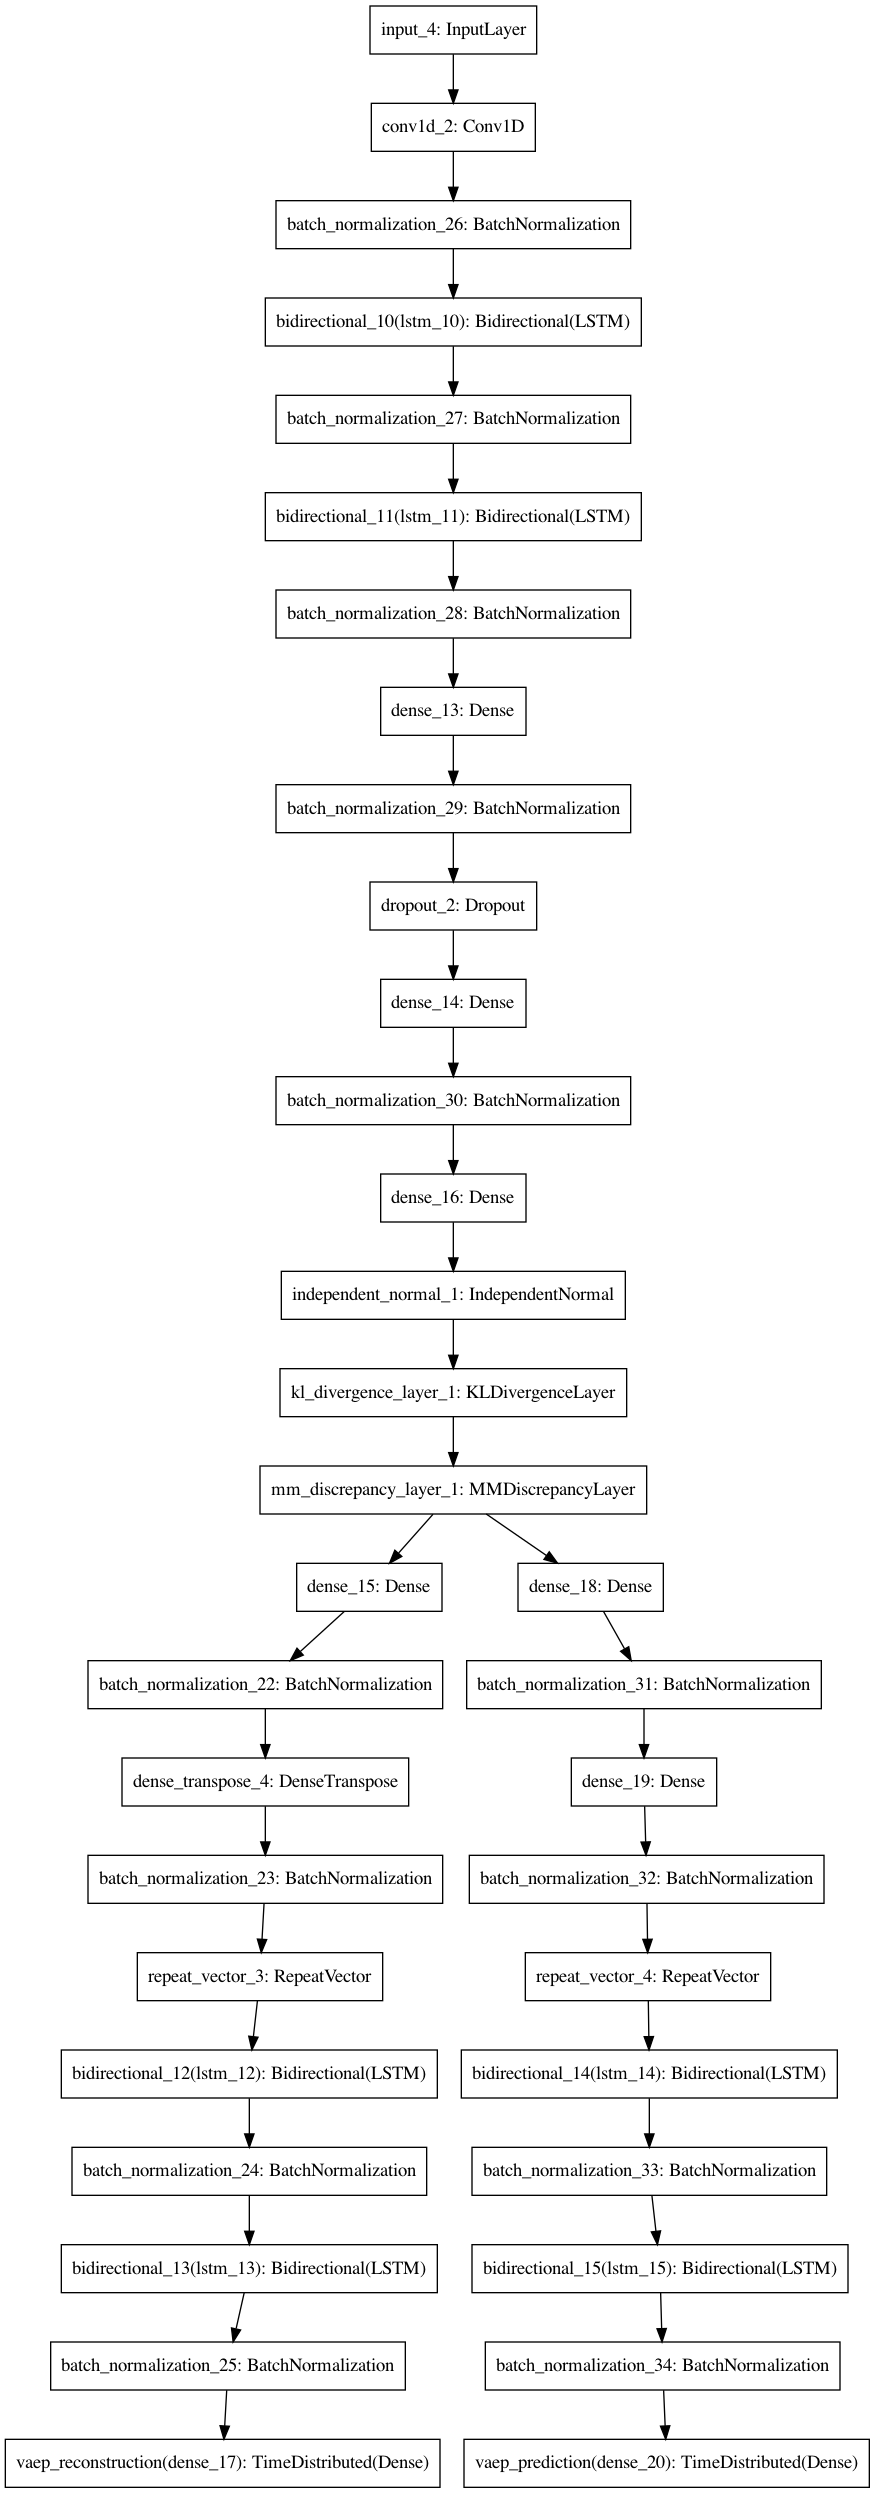

In [31]:
tf.keras.utils.plot_model(vaep)

In [ ]:
# encoder, generator, gmvaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_MMVAEP(pttest.shape,
#                                                                     loss='ELBO+MMD',
#                                                                     number_of_components=2,
#                                                                     kl_warmup_epochs=10,
#                                                                     mmd_warmup_epochs=10).build()
# gmvaep.build(pttest.shape)

In [ ]:
#np.random.shuffle(pttest)
pttrain = pttest[:-15000]
pttest  = pttest[-15000:]

In [ ]:
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-3 * 10**(epoch / 20))

In [ ]:
# tf.config.experimental_run_functions_eagerly(False)
# history = vae.fit(x=pttrain[:-1], y=pttrain[:-1], epochs=100, batch_size=512, verbose=1,
#                   validation_data=(pttest[:-1], pttest[:-1]),
#                   callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

In [ ]:
# tf.config.experimental_run_functions_eagerly(False)
history = vaep.fit(x=pttrain[:-1], y=[pttrain[:-1],pttrain[1:]], epochs=100, batch_size=512, verbose=1,
                   validation_data=(pttest[:-1], [pttest[:-1],pttest[1:]]),
                   callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

In [ ]:
# tf.config.experimental_run_functions_eagerly(False)
# history = gmvaep.fit(x=pttrain[:-1], y=[pttrain[:-1],pttrain[1:]], epochs=2, batch_size=512, verbose=1,
#                      validation_data=(pttest[:-1], [pttest[:-1],pttest[1:]]),
#                      callbacks=[tensorboard_callback, kl_warmup_callback, mmd_warmup_callback])

## Probability playground

In [ ]:
#I need to find a way of using DistributionLambda in my settings, 
#to build a gaussian mixture likelihhod with the proper categorical prior for clustering